# Data Loading

In [1]:
path1 = "Dataset/gauravduttakiit/banknote/versions/1"

print("Path to dataset files:", path1)


TRAIN_PATH = path1 + "/train.csv"
TEST_PATH = path1 + "/test.csv"

Path to dataset files: Dataset/gauravduttakiit/banknote/versions/1


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv(TRAIN_PATH)

In [4]:
df.head()

,VWTI,SWTI,CWTI,EI,Class
0,2.2634,-4.4862,3.6558,-0.612510,0
1,3.2718,1.7837,2.1161,0.613340,0
2,-3.9411,-12.8792,13.0597,-3.312500,1
3,0.5195,-3.2633,3.0895,-0.984900,0
4,2.5698,-4.4076,5.9856,0.078002,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VWTI    1096 non-null   float64
 1   SWTI    1096 non-null   float64
 2   CWTI    1096 non-null   float64
 3   EI      1096 non-null   float64
 4   Class   1096 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 42.9 KB


In [6]:
X = df.drop(columns=['Class'])
y = df['Class']

# Обучение модели

## Базовая модель

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
baseline_model = GradientBoostingClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_valid)

In [9]:
acc = accuracy_score(y_valid, y_pred_base)
prec = precision_score(y_valid, y_pred_base)
rec = recall_score(y_valid, y_pred_base)

In [10]:
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)

Accuracy: 0.9863636363636363
Precision: 0.9767441860465116
Recall: 0.9882352941176471


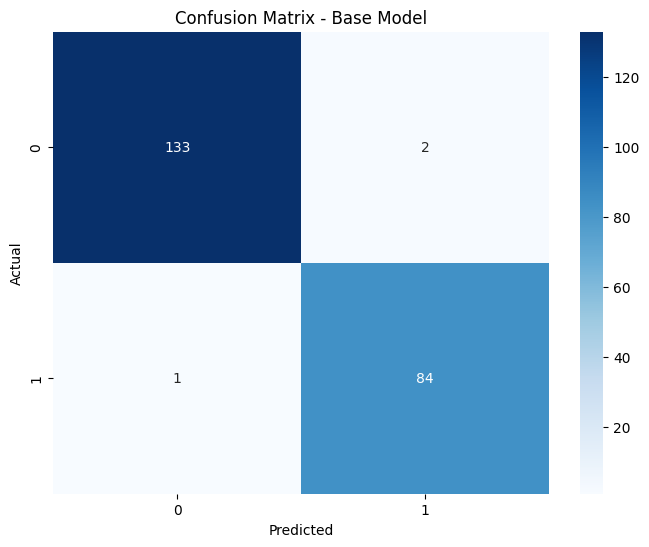

In [11]:
cm = confusion_matrix(y_valid, y_pred_base)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Base Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Улучшенная модель

Попробуем трансформировать имеющиеся фичи, они все численные

In [13]:
def make_engineered(df_in):
    df = df_in.copy()
    nums = df.select_dtypes(include=[np.number]).columns.tolist()

    for i in range(len(nums)):
        for j in range(i + 1, len(nums)):
            a = nums[i]
            b = nums[j]
            df[f"{a}_x_{b}"] = df[a] * df[b]
            df[f"{a}_minus_{b}"] = df[a] - df[b]
            df[f"{a}_abs_minus_{b}"] = np.abs(df[a] - df[b])

    for a in nums:
        df[f"{a}_sq"] = df[a] ** 2
        df[f"{a}_abs"] = np.abs(df[a])
        df[f"{a}_sign"] = np.sign(df[a])

    return df


X_train_fe = make_engineered(X_train)
X_valid_fe = make_engineered(X_valid)

print("Columns before:", X_train.shape[1])
print("Columns after:", X_train_fe.shape[1])

Columns before: 4
Columns after: 34


In [17]:
X_train_fe

,VWTI,SWTI,CWTI,EI,VWTI_x_SWTI,VWTI_minus_SWTI,VWTI_abs_minus_SWTI,VWTI_x_CWTI,VWTI_minus_CWTI,VWTI_abs_minus_CWTI,...,VWTI_sign,SWTI_sq,SWTI_abs,SWTI_sign,CWTI_sq,CWTI_abs,CWTI_sign,EI_sq,EI_abs,EI_sign
2,-3.94110,-12.8792,13.0597,-3.312500,50.758215,8.93810,8.93810,-51.469584,-17.00080,17.00080,...,-1.0,165.873793,12.8792,-1.0,170.555764,13.0597,1.0,10.972656,3.312500,-1.0
6,-2.29870,-5.2270,5.6300,0.917220,12.015305,2.92830,2.92830,-12.941681,-7.92870,7.92870,...,-1.0,27.321529,5.2270,-1.0,31.696900,5.6300,1.0,0.841293,0.917220,1.0
590,4.60140,5.6264,-2.1235,0.193090,25.889317,-1.02500,1.02500,-9.771073,6.72490,6.72490,...,1.0,31.656377,5.6264,1.0,4.509252,2.1235,-1.0,0.037284,0.193090,1.0
634,2.77440,6.8576,-1.0671,0.075416,19.025725,-4.08320,4.08320,-2.960562,3.84150,3.84150,...,1.0,47.026678,6.8576,1.0,1.138702,1.0671,-1.0,0.005688,0.075416,1.0
842,-1.60010,-9.5828,9.4044,0.081882,15.333438,7.98270,7.98270,-15.047980,-11.00450,11.00450,...,-1.0,91.830056,9.5828,-1.0,88.442739,9.4044,1.0,0.006705,0.081882,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.56953,7.6294,1.5754,-3.223300,4.345172,-7.05987,7.05987,0.897238,-1.00587,1.00587,...,1.0,58.207744,7.6294,1.0,2.481885,1.5754,1.0,10.389663,3.223300,-1.0
466,-2.77230,3.2777,-0.9351,-3.145700,-9.086768,-6.05000,6.05000,2.592378,-1.83720,1.83720,...,-1.0,10.743317,3.2777,1.0,0.874412,0.9351,-1.0,9.895428,3.145700,-1.0
121,5.02140,8.0764,-3.0515,-1.715500,40.554835,-3.05500,3.05500,-15.322802,8.07290,8.07290,...,1.0,65.228237,8.0764,1.0,9.311652,3.0515,-1.0,2.942940,1.715500,-1.0
1044,-1.13060,1.8458,-1.3575,-1.380600,-2.086861,-2.97640,2.97640,1.534790,0.22690,0.22690,...,-1.0,3.406978,1.8458,1.0,1.842806,1.3575,-1.0,1.906056,1.380600,-1.0


In [ ]:
X_train_fe = pd.concat(
    [Y_train, X_train_fe[top_features]],
    axis=1
)

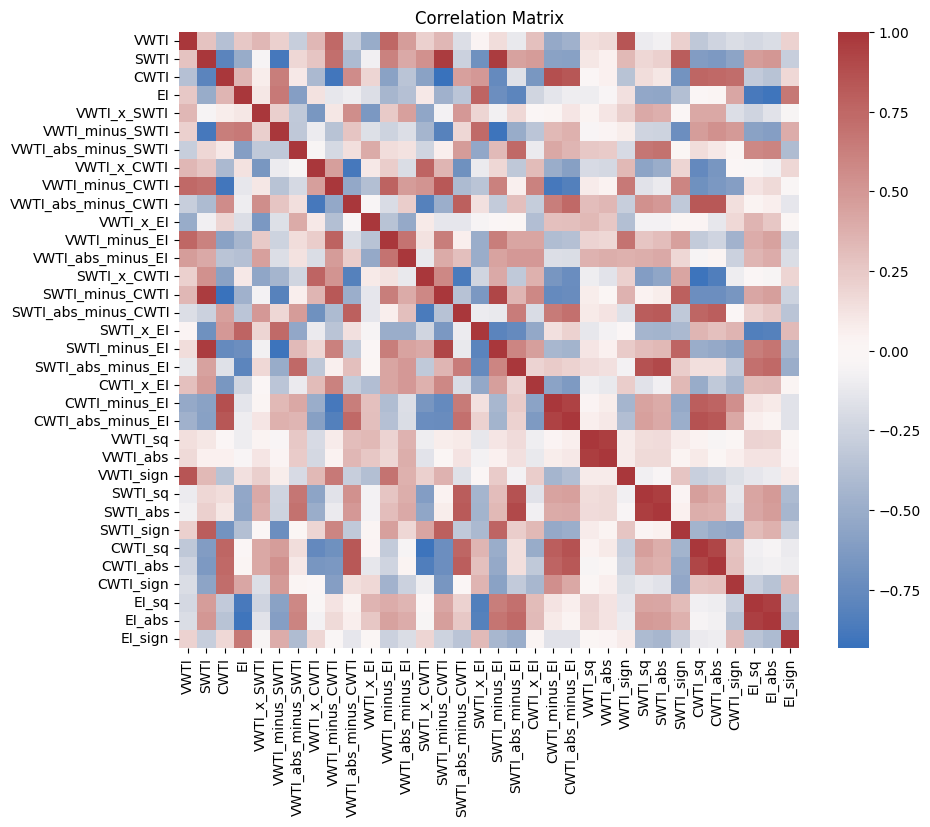

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train_fe.corr(), cmap='vlag', center=0)
plt.title("Correlation Matrix")
plt.show()

In [33]:
numeric_cols_fe = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()


Добавим признаки

In [55]:
top_features = ["VWTI_minus_EI", "SWTI_x_CWTI"]

X_train_imp = pd.concat(
    [X_train, X_train_fe[top_features]],
    axis=1
)

X_valid_imp = pd.concat(
    [X_valid, X_valid_fe[top_features]],
    axis=1
)

Подбор гиперпараметров 

In [63]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_imp, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}


Обучение

In [65]:
improved_model = grid_search.best_estimator_
improved_model.fit(X_train_imp, y_train)
y_pred_imp = improved_model.predict(X_valid_imp)

Метрики

In [66]:
acc_imp = accuracy_score(y_valid, y_pred_imp)
prec_imp = precision_score(y_valid, y_pred_imp)
rec_imp = recall_score(y_valid, y_pred_imp)

In [67]:
print("Improved Accuracy:", acc_imp)
print("Improved Precision:", prec_imp)
print("Improved Recall:", rec_imp)

Improved Accuracy: 1.0
Improved Precision: 1.0
Improved Recall: 1.0


Confusion Matrix

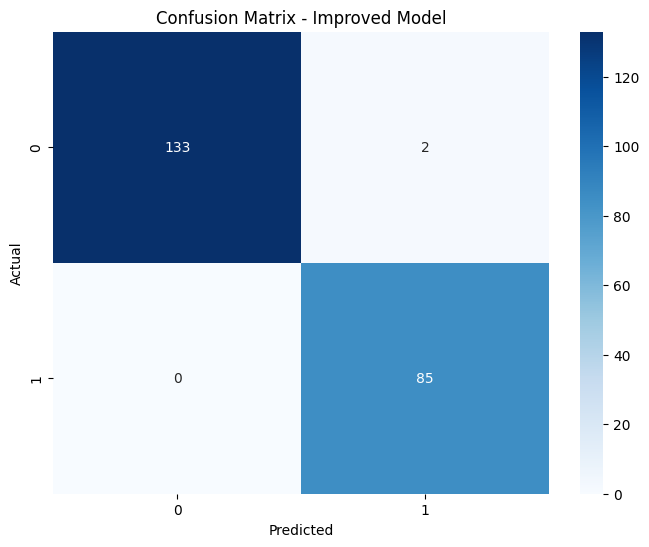

In [61]:
cm_imp = confusion_matrix(y_valid, y_pred_imp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_imp, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Реализованная модель

## Базовая модель

In [37]:
class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1

    def fit(self, X, y, sample_weight):
        n_samples, n_features = X.shape
        min_error = float("inf")

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                for polarity in [1, -1]:
                    predictions = np.ones(n_samples)
                    predictions[polarity * X[:, feature] < polarity * threshold] = 0

                    error = np.sum(sample_weight[predictions != y])

                    if error < min_error:
                        self.feature_index = feature
                        self.threshold = threshold
                        self.polarity = polarity
                        min_error = error

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        idx = self.polarity * X[:, self.feature_index] < self.polarity * self.threshold
        predictions[idx] = 0
        return predictions


In [38]:
class GradientBoostingClassifierScratch:
    def __init__(self, n_estimators=20, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.model_weights = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            stump = DecisionStump()
            stump.fit(X, y, weights)
            preds = stump.predict(X)

            error = np.sum(weights[preds != y])
            error = max(error, 1e-10)

            alpha = self.learning_rate * 0.5 * np.log((1 - error) / error)

            weights *= np.exp(-alpha * ((y * 2 - 1) * (preds * 2 - 1)))
            weights /= np.sum(weights)

            self.models.append(stump)
            self.model_weights.append(alpha)

    def predict(self, X):
        model_preds = np.zeros(X.shape[0])

        for model, alpha in zip(self.models, self.model_weights):
            pred = model.predict(X)
            model_preds += alpha * (pred * 2 - 1)

        return (model_preds > 0).astype(int)


Обучение и предсказание

In [39]:
X_train_np = X_train.values
X_valid_np = X_valid.values

y_train_np = y_train.values
y_valid_np = y_valid.values

In [40]:
gb_imp = GradientBoostingClassifierScratch()

gb_imp.fit(X_train_np, y_train_np)
y_pred_imp = gb_imp.predict(X_valid_np)

In [41]:
print("Accuracy:", accuracy_score(y_valid_np, y_pred_base))
print("Precision:", precision_score(y_valid_np, y_pred_base))
print("Recall:", recall_score(y_valid_np, y_pred_base))

Accuracy: 0.9863636363636363
Precision: 0.9767441860465116
Recall: 0.9882352941176471


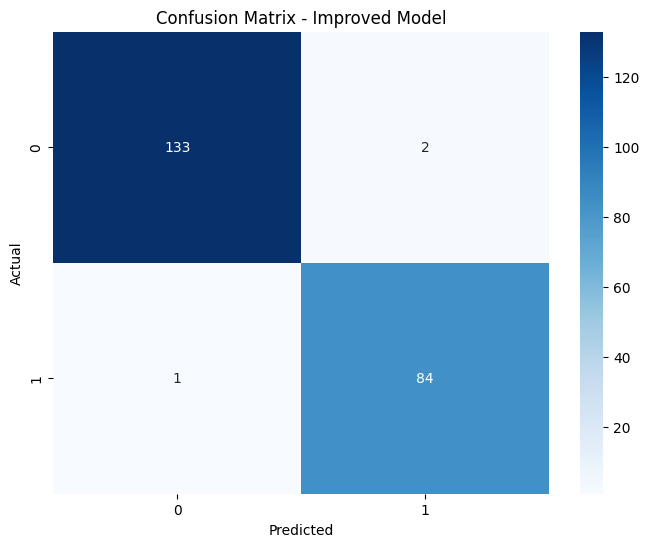

In [50]:
cm_base = confusion_matrix(y_valid, y_pred_base)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Улучшенная модель

Добавим пару признаков

In [44]:
top_features = ["VWTI_minus_EI", "SWTI_x_CWTI"]

X_train_imp = pd.concat(
    [X_train, X_train_fe[top_features]],
    axis=1
)

X_valid_imp = pd.concat(
    [X_valid, X_valid_fe[top_features]],
    axis=1
)

In [45]:
X_train_imp_np = X_train_imp.values
X_valid_imp_np = X_valid_imp.values

Обучение и предикт

In [48]:
gb_imp = GradientBoostingClassifierScratch(
    n_estimators=200,
    learning_rate=0.2
)

gb_imp.fit(X_train_imp_np, y_train_np)
y_pred_imp = gb_imp.predict(X_valid_imp_np)

In [49]:
print("Accuracy:", accuracy_score(y_valid_np, y_pred_imp))
print("Precision:", precision_score(y_valid_np, y_pred_imp))
print("Recall:", recall_score(y_valid_np, y_pred_imp))

Accuracy: 0.9863636363636363
Precision: 0.9659090909090909
Recall: 1.0


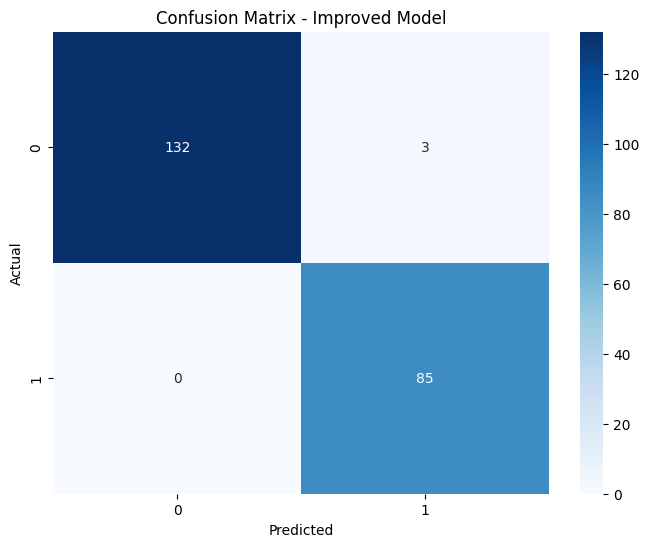

In [53]:
cm_imp = confusion_matrix(y_valid, y_pred_imp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_imp, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Достигли 1.0 метрики Recall

# Регрессия Data Loading

# Результаты

## Классификация

In [70]:
results_dfc = pd.DataFrame({
    'Модель': ['Базовая модель', 'Улучшенная модель', 
               'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'Accuracy': [0.9863636363636363, 1.0, 
                 0.9863636363636363, 0.9863636363636363],
    'Precision': [0.9767441860465116, 1.0, 
                  0.9767441860465116, 0.9659090909090909],
    'Recall': [0.9882352941176471, 1.0, 
               0.9882352941176471, 1.0]
})

In [71]:
results_dfc

,Модель,Accuracy,Precision,Recall
0,Базовая модель,0.986364,0.976744,0.988235
1,Улучшенная модель,1.000000,1.000000,1.000000
2,Реализованная базовая модель,0.986364,0.976744,0.988235
3,Улучшенная реализованная модель,0.986364,0.965909,1.000000


## Регрессия